# Hopefully final notebook for semantic segmentation component

In [ ]:
# install nondefault colab libraries
!pip install datasets torchinfo torchmetrics datasets[vision]

In [ ]:
# entire code is being run on an Ubuntu kernel.
# not many QoL libraries are needed.
# your mileage may vary.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
%matplotlib inline

# dataset imports
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize

# AI imports
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList
from torch.nn import Sequential, Softmax, CrossEntropyLoss, ReLU, BatchNorm2d
from torch.nn import functional as F
from torch.cuda.amp import autocast, GradScaler
import torch

# statistics
from torchinfo import summary
import torchmetrics as TM

# test if GPU acceleration is working
torch.cuda.is_available()

True

## Standard Helper Functions

In [ ]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join("./models/", cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )


# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()


def get_model_parameters(m):
    total_params = sum(param.numel() for param in m.parameters())
    return total_params


def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")


# end if


def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()


t2img = transforms.ToPILImage()

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


## Dataset Loading and Initialization

### all of this was made to run on my local machine, which no longer works due to memory issues.

In [ ]:
# load in the ade20k pickle file to examine it.
root = "./ade20k/ADEChallengeData2016/"
images_dir = f"{root}/images"
annotations_dir = f"{root}/annotations"

In [ ]:
images_training_dir = f"{images_dir}/training"
annotations_training_dir = f"{annotations_dir}/training"

images_validation_dir = f"{images_dir}/validation"
annotations_validation_dir = f"{annotations_dir}/validation"

# training_images = sorted(os.listdir(images_training_dir))
# print(len(training_images))

# training_annotations = sorted(os.listdir(annotations_training_dir))
# print(len(training_annotations))

# Turns out that this dataset is on HuggingFace Datasets, so we'll see where we can go from there

In [ ]:
dataset = load_dataset("scene_parse_150")

In [ ]:
# custom loader that probably won't be needed anymore
class ADE20KDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None, target_transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.target_transforms = target_transforms
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(annotations_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]

        img_name = os.path.join(self.images_dir, image_filename)
        image = Image.open(img_name).convert("RGB")

        # Generate the mask filename based on the image filename
        mask_filename = image_filename.replace(".jpg", ".png")
        mask_name = os.path.join(self.annotations_dir, mask_filename)

        mask = Image.open(mask_name)

        if self.transforms:
            image = self.transforms(image)
        if self.target_transforms:
            mask = self.transforms(mask)

        return image, mask

### DETOUR 1: Find a good size to scale all images to for all models moving forward

In [ ]:
# This detour is no longer being run because it takes too much space,
# and the result out of it is no longer valid (due to various memory issues),
if False:
    img_h, img_w = np.zeros((len(training_images))), np.zeros((len(training_images)))
    for idx in range(len(training_images)):
        timg = read_image(images_training_dir + "/" + training_images[idx])
        img_h[idx] = timg.shape[1]
        img_w[idx] = timg.shape[2]

    image_size = pd.DataFrame({"H": img_h, "W": img_w}, dtype="int")
    image_size["ratio"] = image_size["H"] / image_size["W"]
    image_size.hist()

In [ ]:
# Let's see how many samples we will be alienating from the dataset
# image_size[image_size["H"] > 768].shape[0] + image_size[image_size["W"] > 768].shape[0]

In [ ]:
dataset = dataset
train, test, val = dataset["train"].with_format("torch"), dataset["test"].with_format("torch"), dataset["validation"].with_format("torch")
train[0], test[0], val[0]

({'image': tensor([[[ 29,  27,  28],
           [ 29,  27,  28],
           [ 28,  28,  28],
           ...,
           [137, 119, 159],
           [130, 112, 154],
           [132, 114, 162]],
  
          [[ 29,  27,  28],
           [ 29,  27,  28],
           [ 28,  28,  28],
           ...,
           [139, 121, 161],
           [137, 119, 161],
           [142, 125, 170]],
  
          [[ 29,  27,  28],
           [ 29,  27,  28],
           [ 28,  28,  28],
           ...,
           [138, 120, 160],
           [140, 122, 164],
           [134, 117, 162]],
  
          ...,
  
          [[255, 240, 239],
           [ 42,  18,  18],
           [ 18,   0,   0],
           ...,
           [110,  59,  40],
           [107,  58,  41],
           [102,  56,  40]],
  
          [[255, 249, 248],
           [ 50,  26,  26],
           [ 26,   0,   1],
           ...,
           [118,  70,  48],
           [122,  76,  53],
           [106,  63,  44]],
  
          [[252, 231, 230],
     

#### /DETOUR 1

### create data loaders

In [ ]:
train_batch = 8
val_batch = 4
target_size = 384 # for the purposes of segmentation for attention masks we feel
                  # higher resolution images are important.

imgtransform = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.Resize((target_size)),
        transforms.ToTensor(),
    ]
)

msktransform = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.Resize((target_size)),
    ]
)


import torch
import torch.nn.functional as F

def irregular_image_collate(batch):
    inputs, targets = [], []

    # Define the resize transform
    resize_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    max_height, max_width = 0, 0

    for i in batch:
        # Apply resize transform to the image
        resized_image = resize_transform(i["image"].permute(2, 0, 1))

        inputs.append(resized_image)

        resized_annotation = resize_transform(i["annotation"].unsqueeze(2).permute(2, 0, 1))
        targets.append(resized_annotation)

        # Update max height and width
        max_height = max(max_height, resized_image.size(1), resized_annotation.size(1))
        max_width = max(max_width, resized_image.size(2), resized_annotation.size(2))

    # pad each input and target image to the maximum size
    padded_inputs = [
        F.pad(img, (0, max_width - img.size(2), 0, max_height - img.size(1)))
        for img in inputs
    ]

    padded_targets = [
        F.pad(img, (0, max_width - img.size(2), 0, max_height - img.size(1)))
        for img in targets
    ]

    del inputs, targets

    # stack the padded inputs and targets to create the batch
    padded_inputs = torch.stack(padded_inputs, dim=0)
    padded_targets = torch.stack(padded_targets, dim=0)

    return padded_inputs, padded_targets


In [ ]:
# make dataloaders for training and testing piplelines
train_loader = DataLoader(train, batch_size=train_batch, shuffle=False,
                          collate_fn=irregular_image_collate
                          )

val_loader = DataLoader(val, batch_size=val_batch, shuffle=False,
                        collate_fn=irregular_image_collate
                        )

## Test Dataloader

In [ ]:
def visualize_image_mask(image, mask):
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        image # .permute(1, 2, 0)
    )  # for visualization we have to transpose back to HWC
    plt.subplot(1, 2, 2)
    # Turn off tick labels
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        mask # .permute(1, 2, 0)
    )  # for visualization we have to remove 3rd dimension of mask
    plt.show()

In [ ]:
image = train[0]["image"]
mask = train[0]["annotation"]
print(image.shape)
print(mask.shape)

torch.Size([480, 753, 3])
torch.Size([480, 753])


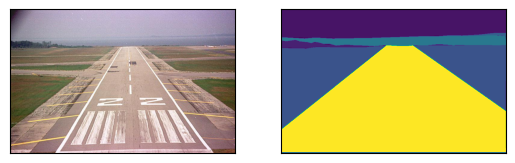

In [ ]:
visualize_image_mask(image, mask)

## Everything is in order, time to build the model and train it!

## Model Definition

In [ ]:
class DoubleConv(Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = Sequential(
            Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            BatchNorm2d(out_channels),
            ReLU(inplace=True),
            Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            BatchNorm2d(out_channels),
            ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256],
    ):
        super(UNet, self).__init__()
        self.ups = ModuleList()
        self.downs = ModuleList()
        self.pool = MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                ConvTranspose2d(
                    feature*2, feature, kernel_size=4, stride=2, padding=1, bias=False
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = Conv2d(features[0], out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
model = UNet(in_channels=3, out_channels=151)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
# test model with dummy batch
with torch.autocast(device_type="cuda"):
    print(summary(model, input_size=(train_batch, 3, target_size, target_size)))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 151, 384, 384]        --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-1                   [8, 64, 384, 384]         --
│    │    └─Sequential: 3-1              [8, 64, 384, 384]         38,848
├─MaxPool2d: 1-2                         [8, 64, 192, 192]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-2                   [8, 128, 192, 192]        --
│    │    └─Sequential: 3-2              [8, 128, 192, 192]        221,696
├─MaxPool2d: 1-4                         [8, 128, 96, 96]          --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-3                   [8, 256, 96, 96]          --
│    │    └─Sequential: 3-3              [8, 256, 96, 96]          885,760
├─MaxPool2d: 1-6                         [8,

### IoU Loss Functions

In [ ]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = Softmax(dim=1)(pred).to("cuda")

    # Add the one-hot encoded masks for all 150 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([(gt == i) for i in range(151)], dim=1).to("cuda")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()


class IoULoss(Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())


def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 151, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z


test_custom_iou_loss()

tensor(5.6941, device='cuda:0', grad_fn=<NegBackward0>)

## Model Training

### Helper Functions

In [ ]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()


def print_test_dataset_masks(
    model, test_targets, test_labels, epoch, save_path, show_plot, batch_size=2, resize_input=None
):
    model.eval()  # Set the model to evaluation mode
    model = model.to("cuda")  # Ensure the model is on the GPU
    to_device(model)
    model.half()

    with torch.no_grad(), autocast():
        # Move input tensors to the GPU
        selected_targets = test_targets.to("cuda").half()
        selected_labels = test_labels.to("cuda").half()

        # Evaluation metrics on CPU
        iou = TM.classification.MulticlassJaccardIndex(151, average="micro")
        pixel_metric = TM.classification.MulticlassAccuracy(151, average="micro")

        # Iterate through batches
        for i in range(0, selected_targets.size(0), batch_size):
            batch_targets = selected_targets[i:i + batch_size]
            batch_labels = selected_labels[i:i + batch_size]

            # Forward pass
            predictions = model(batch_targets)
            pred = torch.nn.functional.softmax(predictions, dim=1)
            pred_labels = pred.argmax(dim=1).unsqueeze(1).to(torch.float)

            # Move predictions and labels to the CPU for metric computation
            pred_labels_cpu = pred_labels.cpu()
            selected_labels_cpu = batch_labels.cpu()

            # Compute metrics
            iou_accuracy = iou(pred_labels_cpu, selected_labels_cpu)
            pixel_accuracy = pixel_metric(pred_labels_cpu, selected_labels_cpu)
            custom_iou = IoUMetric(pred, selected_labels_cpu)

            title = f"Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]"
            print(title)

    close_figures()

    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(title, fontsize=12)

    # Limit the number of samples to visualize
    num_samples = min(batch_size, selected_targets.size(0))

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(make_grid(selected_targets[:num_samples], nrow=num_samples)))
    plt.axis("off")
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(make_grid(selected_labels[:num_samples].float() / 2.0, nrow=num_samples)))
    plt.axis("off")
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(make_grid(pred_labels[:num_samples] / 2.0, nrow=num_samples)))
    plt.axis("off")
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(
            os.path.join(save_path, f"epoch_{epoch:02}.png"),
            format="png",
            bbox_inches="tight",
            pad_inches=0.4,
        )

    if not show_plot:
        close_figures()
    else:
        plt.show()

In [ ]:
def test_dataset_accuracy(model, loader):
    model.eval()
    iou = TM.classification.MulticlassJaccardIndex(150, average="micro")
    pixel_metric = TM.classification.MulticlassAccuracy(150, average="micro")

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    inputs, targets = next(iter((loader, 0)))
    predictions = model(inputs)
    print(predictions[0, 1, :, :])

    pred_probabilities = Softmax(dim=1)(predictions)
    pred_labels = predictions.argmax(dim=1)

    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    iou_accuracy = iou(pred_mask, targets)
    # pixel_accuracy = pixel_metric(pred_mask, targets)
    pixel_accuracy = pixel_metric(pred_labels, targets)
    custom_iou = IoUMetric(pred_probabilities, targets)
    iou_accuracies.append(iou_accuracy.item())
    pixel_accuracies.append(pixel_accuracy.item())
    custom_iou_accuracies.append(custom_iou.item())

    del inputs
    del targets
    del predictions

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(
        f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}"
    )

### DETOUR 2: A little Sanity check

In [ ]:
torch.cuda.empty_cache()
save_path = os.path.join("./logs/", "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
# train_x, train_y = next(iter(val_loader))
# print_test_dataset_masks(
#     model, train_x, train_y, epoch=0, save_path=None, show_plot=True, batch_size=4
# )

/DETOUR 2

### Core training definition

In [ ]:
# Optimizer and Learning Rate Scheduler.
to_device(model.train())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [ ]:
# Train the model for a single epoch
def train_model(model, loader, optimizer, cel=True, epoch=1, gradient_accumulation_steps=2):
    to_device(model.train())

    if cel:
        criterion = CrossEntropyLoss(reduction="mean")
    else:
        criterion = IoULoss(softmax=True)

    scaler = GradScaler()

    running_loss = 0.0
    running_samples = 0

    # Use tqdm to create a progress bar for the training loop
    progress_bar = tqdm(enumerate(loader, 1), total=len(loader), desc=f'Epoch {epoch}', dynamic_ncols=True)

    for batch_id, (inputs, targets) in progress_bar:
        inputs, targets = inputs.half().to("cuda"), targets.to("cuda")

        with autocast():
            predictions = model(inputs)
            if cel:
                targets = targets.squeeze(dim=1)
                targets = targets.long()
            loss = criterion(predictions, targets)

            del inputs, predictions
            # Scale the loss for gradient accumulation
            loss = loss / gradient_accumulation_steps

            # Perform backpropagation only every `gradient_accumulation_steps` batches
            scaler.scale(loss).backward()

            if batch_id % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_samples += targets.size(0)
            running_loss += loss.item()

            del targets
        # Display the averaged loss over the entire epoch
        if batch_id % gradient_accumulation_steps == 0 or batch_id == len(loader):
            progress_bar.set_postfix(loss=f'{running_loss / running_samples:.4f}')

        del loss
        torch.cuda.empty_cache()

    progress_bar.close()

    # Release GPU memory explicitly
    torch.cuda.empty_cache()

    # Move loss calculation to CPU
    running_loss /= running_samples

    # Clean up
    del inputs, targets, predictions, loss

In [ ]:
def train_loop(model, loader, test_loader, epochs, optimizer, scheduler, save_path):
    epoch_i, epoch_j = epochs

    # Move model to GPU and set to training mode
    model = model.to("cuda")
    to_device(model)
    model.train()

    # Define metrics and loss function
    iou_metric = TM.classification.MulticlassJaccardIndex(151, average="micro")
    pixel_metric = TM.classification.MulticlassAccuracy(151, average="micro")
    criterion = IoULoss(softmax=True).to("cuda")

    for epoch in tqdm(range(epoch_i, epoch_j)):
        print(f"Epoch: {epoch:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Training
        train_model(model, loader, optimizer, cel=True, epoch=epoch)

        # Evaluation
        model.eval()
        with torch.no_grad(), autocast():
            test_inputs, test_targets = next(iter(test_loader))
            test_inputs, test_targets = test_inputs.to("cuda").half(), test_targets.to("cuda").half()

            # Forward pass
            predictions = model(test_inputs)
            pred = torch.nn.functional.softmax(predictions, dim=1)
            pred_labels = pred.argmax(dim=1).unsqueeze(1).to(torch.float)

            # Compute metrics on CPU
            iou_accuracy = iou_metric(pred_labels.cpu(), test_targets.cpu())
            pixel_accuracy = pixel_metric(pred_labels.cpu(), test_targets.cpu())
            custom_iou = IoUMetric(pred, test_targets.cpu())

            title = f"Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]"
            print(title)

            # Save figures only at the end of training
            if epoch == epoch_j - 1:
                print_test_dataset_masks(
                    model,
                    test_inputs,
                    test_targets,
                    epoch=epoch,
                    save_path=save_path,
                    show_plot=True,
                )

        # Learning rate scheduler step
        if scheduler is not None:
            scheduler.step()

        # Release GPU memory explicitly
        torch.cuda.empty_cache()

        print("")

In [ ]:
# Train our model for a fixed number of epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each image in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively.
torch.cuda.empty_cache()
model_timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = os.path.join("./logs/", "model-training-" + model_timestamp)
os.makedirs(save_path, exist_ok=True)
train_loop(model,
    train_loader,
    val_loader,
    (1, 6),
    optimizer,
    scheduler,
    save_path)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 01, Learning Rate: 0.001



  0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
checkpoint = model.state_dict(),
checkpoint_timestamp = datetime.datetime.now().strftime("%H:%M")
torch.save(checkpoint, f"./model_{model_timestamp}-checkpoint_{checkpoint_timestamp}.pth")

In [ ]:
print(type(checkpoint))

<class 'tuple'>
